# 2.2 Neural network

Columns dropped due to too many missing values: Index(['Nenana: Mean water temperature [C]', 'IceThickness [cm]',
       'Regional: Solar Surface Irradiance [W/m2]',
       'Regional: Cloud coverage [%]',
       'Global: ENSO-Southern oscillation index',
       'Gulkana: Glacier-wide winter mass balance [m.w.e]',
       'Gulkana: Glacier-wide summer mass balance [m.w.e]',
       'Global: Pacific decadal oscillation index',
       'Global: Artic oscillation index'],
      dtype='object')


C:\Users\gabri\AppData\Local\Temp\ipykernel_1236\115250856.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 3803.7114 - val_loss: 1219.0291
Epoch 2/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 973.2978 - val_loss: 501.9391
Epoch 3/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 429.1904 - val_loss: 238.0605
Epoch 4/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 217.7436 - val_loss: 133.1575
Epoch 5/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 132.6611 - val_loss: 82.8101
Epoch 6/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 92.3185 - val_loss: 62.3611
Epoch 7/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 72.9649 - val_loss: 52.7478
Epoch 8/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 67.3924 - val_loss: 47.9968
Epoch 9/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 62.4149 - val_loss: 43.6349
Epoch 10/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 59.1674 - val_loss: 41.4429
Epoch 11/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 58.8867 - val_loss: 41.6905
Epoch 12/50
326/32

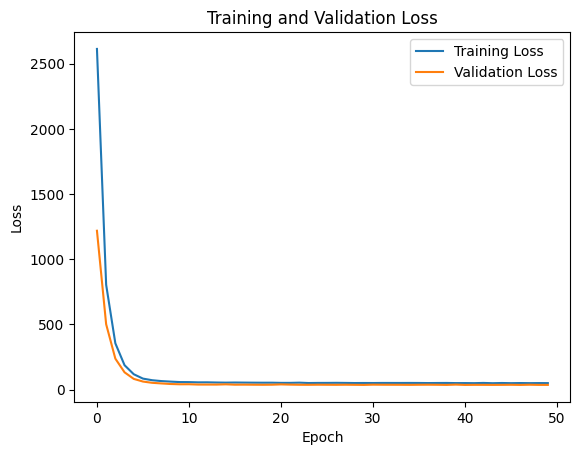

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38.1814
Mean Squared Error: 36.758056640625
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


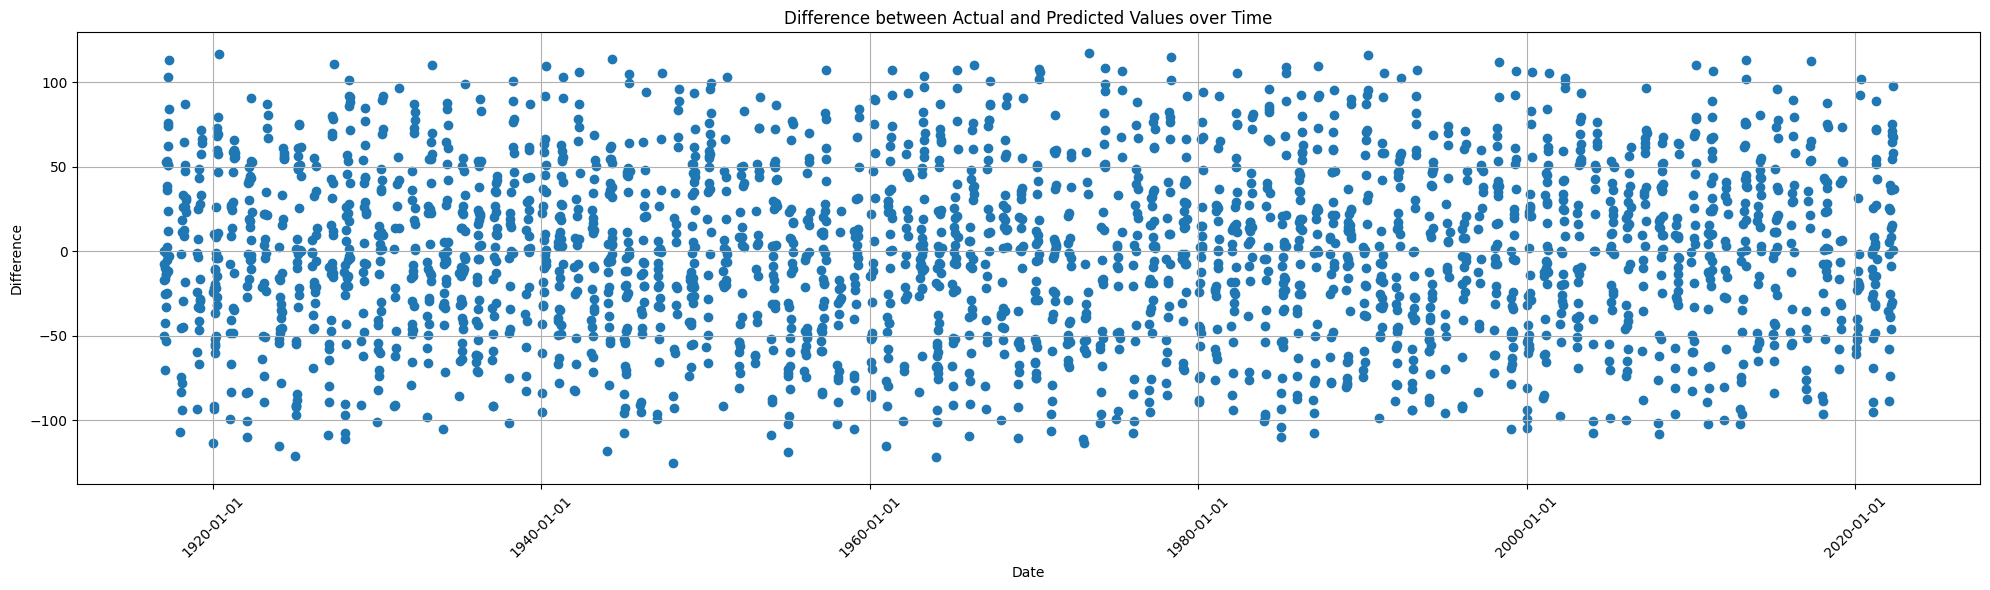

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import matplotlib.dates as mdates





data=pd.read_csv('https://raw.githubusercontent.com/iceclassic/sandbox/main/Data/Time_series_DATA.txt',index_col=0,skiprows=149)
data.index = data.index.astype(str).str.split().str[0]
data.index = pd.to_datetime(data.index, format="%Y-%m-%d")

data = data[data['Days until break up'] < 0]
# Drop columns with many missing values and any unnecessary columns
dropped_columns = data.columns[data.isnull().mean() > 0.9]
data = data.dropna(thresh=len(data) * 0.9, axis=1).dropna(subset=['Days until break up'])
print("Columns dropped due to too many missing values:", dropped_columns)

# Fill missing values with mean
data.fillna(method='ffill', inplace=True)
# Splitting data into features and target
X = data.drop(columns=['Days until break up'])
y = data['Days until break up']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM input (samples, time steps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define model architecture
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  # Add dropout after each LSTM layer
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))  # Add return_sequences=True to keep the sequence
model.add(Dropout(0.2))
model.add(LSTM(units=128))  # No return_sequences=True here, as this is the last LSTM layer
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train model and plot loss
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Extract loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate model
mse = model.evaluate(X_test_reshaped, y_test)
print("Mean Squared Error:", mse)

# Make predictions
predictions = model.predict(X_test_reshaped)

# Sort test DataFrame by index
y_test_sorted = y_test.sort_index()
predictions_sorted = pd.Series(predictions.squeeze(), index=y_test_sorted.index)

# Calculate the difference between actual and predicted values
difference = y_test_sorted - predictions_sorted

# Plot difference between actual and predicted values over time
plt.figure(figsize=(20, 6))
plt.scatter(y_test_sorted.index, difference)
plt.title('Difference between Actual and Predicted Values over Time')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format x-axis as date
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto date locator
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.grid(True)  # Add grid for better visualization
plt.show()


>Now do the same but with the dataframe corresponding to the selected variables
> How do we deal with missing data (interp,resampling)?
>Repeat but now filter the df to consider only days since oct1 to may 15

> WE could do Hyperparameter tunning, but the base NN is not very good, so the effect of thi will be difficult to see

